In [1]:
import multiprocessing as mp
import subprocess
import sys
import os
import itertools
from scipy.io import savemat
from scipy.io import loadmat
import numpy as np

##  Pauli+ simulation

In [2]:
mp.cpu_count()
n2 = 9 ; k = 4 ;
max_num_cycles = 6

In [3]:
set_basis_type = ["Z", "X"];
set_basis_type = ["X"];
set_budget_component = ["CZ", "crosstalk", "leakage", "SQ", "DD", "idle", "readout", "Excess"] ;

set_num_cycles = range(1, max_num_cycles+1)

args = [(basis, budget_component, num_cycles) for basis in set_basis_type for budget_component in set_budget_component 
               for num_cycles in set_num_cycles ]

In [ ]:
script = "Budget_PauliPlus_sim.py"

def run_Budget_PauliPlus_sim(basis_type, budget_component, num_cycles):
    subprocess.run([sys.executable, script, str(basis_type), str(budget_component), str(num_cycles) ])

with mp.Pool(processes = 130) as pool:
    pool.starmap(run_Budget_PauliPlus_sim, args)

## Error decoding

In [ ]:
script2 = "Error_decoding.py"

def run_error_decoding(basis_type, budget_component, num_cycles):
    subprocess.run([sys.executable, script2, str(basis_type), str(budget_component), str(num_cycles) ])

with mp.Pool(processes = 130) as pool:
    pool.starmap(run_error_decoding, args)

## Load the results

In [4]:
from scipy.optimize import curve_fit
from matplotlib import font_manager 
font_manager.fontManager.addfont('Arial.ttf')

In [5]:
sim_Z_logic_error = {};
sim_Z_logic_error_perbit = {};
sim_X_logic_error = {};
sim_X_logic_error_perbit = {} ;

for budget_component in set_budget_component:
    for num_cycles in range(1, max_num_cycles+1):
        fname = './Numerical_results/' + 'Logical_Z_' + 'cycle_' + str(num_cycles) + 'budget_' + budget_component + '.mat'
        data = loadmat(fname)
        sim_Z_logic_error.setdefault(budget_component, []).append( data['logical_error_probability'][0][0]  )
        sim_Z_logic_error_perbit.setdefault(budget_component, []).append(data['logical_error_probability_per_qubit'][0])

    for num_cycles in range(1, max_num_cycles+1):
        fname = './Numerical_results/' + 'Logical_X_' + 'cycle_' + str(num_cycles) + 'budget_' + budget_component + '.mat'
        data = loadmat(fname)
        sim_X_logic_error.setdefault(budget_component, []).append( data['logical_error_probability'][0][0] )
        sim_X_logic_error_perbit.setdefault(budget_component, []).append(data['logical_error_probability_per_qubit'][0])

for num_cycles in range(1, max_num_cycles+1):
    fname = '../Numerical_results/' + 'Logical_Z_' + 'num_cycles_' + str(num_cycles) + '.mat'
    data = loadmat(fname)
    sim_Z_logic_error.setdefault("None", []).append( data['logical_error_probability'][0][0]  )
    sim_Z_logic_error_perbit.setdefault("None", []).append(data['logical_error_probability_per_qubit'][0])

    fname2 = '../Numerical_results/' + 'Logical_X_' + 'num_cycles_' + str(num_cycles) + '.mat'
    data2 = loadmat(fname2)
    sim_X_logic_error.setdefault("None", []).append( data2['logical_error_probability'][0][0]  )
    sim_X_logic_error_perbit.setdefault("None", []).append(data2['logical_error_probability_per_qubit'][0])

In [6]:
# sim_Z_logic_error

In [7]:
set_sim_num_z = {} ; set_sim_num_x = {} ;

for budget_component in set_budget_component:
    for num_cycles in range(1, max_num_cycles+1):
        fname = './Numerical_data/' + 'Logical_Z_' + 'cycle_' + str(num_cycles) + 'budget_' + budget_component + '.mat'
        data = loadmat(fname)
        set_sim_num_z.setdefault(budget_component, []).append(data["retained_num_samples"][0][0])

    for num_cycles in range(1, max_num_cycles+1):
        fname = './Numerical_data/' + 'Logical_X_' + 'cycle_' + str(num_cycles) + 'budget_' + budget_component + '.mat'
        data = loadmat(fname)
        set_sim_num_x.setdefault(budget_component, []).append(data["retained_num_samples"][0][0])

for num_cycles in range(1, max_num_cycles+1):
    fname = '../Numerical_data/' + 'Logical_Z_' + 'num_cycles_' + str(num_cycles) + '.mat'
    data = loadmat(fname)
    set_sim_num_z.setdefault("None", []).append(data["retained_num_samples"][0][0])

    fname2 = '../Numerical_data/' + 'Logical_X_' + 'num_cycles_' + str(num_cycles) + '.mat'
    data2 = loadmat(fname2)
    set_sim_num_x.setdefault("None", []).append(data2["retained_num_samples"][0][0])

In [8]:
# set_sim_num_z

## Logical Z state

In [9]:
def k_to_one(p, k):
    return 1-(1-p)**(1/k)
    
cycle_t = np.arange(1, max_num_cycles+1) ;
cycle_interpo = np.linspace(1, max_num_cycles+1, 100) ;

In [10]:
set_budget_component

['CZ', 'crosstalk', 'leakage', 'SQ', 'DD', 'idle', 'readout', 'Excess']

In [11]:
set_logical_error_Z_perbit_percycle = {} ;

for bc in ["None"] + set_budget_component  :
    temp_logical = sim_Z_logic_error[bc]
    temp_num     = set_sim_num_z[bc]
    
    eta = 1
    sim_Z_logic_fid = 1 - eta * np.array( temp_logical )
    log_sim_Z_logic_fid = np.log(sim_Z_logic_fid)
    
    sigma_sim_Z_logic_error = [ np.sqrt(item*(1-item)/sim_num) for item, sim_num in zip(temp_logical, temp_num)];
    
    coeff, cov = np.polyfit(cycle_t, log_sim_Z_logic_fid, deg=1, cov=True)
    
    log_A, log_B = coeff  # [Slope, intercept]
    
    sigma_log_A = np.sqrt(cov[0,0]) ;
    sim_sigma_pL_z = np.exp(log_A) * sigma_log_A ;  #
    
    A = np.exp(log_A)
    B = np.exp(log_B)
    
    sim_Z_logic_error_percycle = (1 - A)/eta
    # print(f"Logical error rate for four logical qubits per cycle = {sim_Z_logic_error_percycle} ± {sim_sigma_pL_z}")
    
    # The fit line
    pred_sim_Z_logic_error = (1 - B * A**(cycle_interpo))/eta
    
    sim_Z_logic_error_perbit_percycle = k_to_one(sim_Z_logic_error_percycle, k)
    
    sim_sigma_pL_z_perbit = sim_sigma_pL_z / (k * (1 - sim_Z_logic_error_percycle )**(1-1/k)    )
    
    print("logical error per logical qubit per cycle:",  sim_Z_logic_error_perbit_percycle )
    # print("The error bar is:",  sim_sigma_pL_z_perbit)
    set_logical_error_Z_perbit_percycle.setdefault(bc, []).append(sim_Z_logic_error_perbit_percycle)

logical error per logical qubit per cycle: 0.08359936425912551
logical error per logical qubit per cycle: 0.05849375735414164
logical error per logical qubit per cycle: 0.07324657472754725
logical error per logical qubit per cycle: 0.08276864028520281
logical error per logical qubit per cycle: 0.07721633891055735
logical error per logical qubit per cycle: 0.06976937539997952
logical error per logical qubit per cycle: 0.07762873948859494
logical error per logical qubit per cycle: 0.07691362700765203
logical error per logical qubit per cycle: 0.05321928334751291


In [12]:
reduced_logical_error_component_Z = {key: set_logical_error_Z_perbit_percycle["None"][0] - value[0] 
                                            for key, value in set_logical_error_Z_perbit_percycle.items() }

In [13]:
print("logical error per logical qubit per cycle:", set_logical_error_Z_perbit_percycle["None"][0] )

logical error per logical qubit per cycle: 0.08359936425912551


In [14]:
# reduced_logical_error_component_Z

In [15]:
temp_sum = sum(reduced_logical_error_component_Z.values())
Z_component_contribution = {key:value/temp_sum for key, value in reduced_logical_error_component_Z.items()}

In [58]:
Z_component_contribution

{'None': 0.0,
 'CZ': 0.25221986814021874,
 'crosstalk': 0.10400781070222775,
 'leakage': 0.008345748898111969,
 'SQ': 0.06412614591810321,
 'DD': 0.13894099352531614,
 'idle': 0.05998302283777872,
 'readout': 0.06716729750325359,
 'Excess': 0.3052091124749899}

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## test

In [ ]:
# sim_Z_logic_error["initial_readout"]

In [ ]:
bc = "DD"
temp_logical = sim_Z_logic_error[bc][:]
temp_num     = set_sim_num_z[bc][:]

eta = 1
sim_Z_logic_fid = 1 - eta * np.array( temp_logical )
log_sim_Z_logic_fid = np.log(sim_Z_logic_fid)

sigma_sim_Z_logic_error = [ np.sqrt(item*(1-item)/sim_num) for item, sim_num in zip(temp_logical, temp_num)];

coeff, cov = np.polyfit(cycle_t, log_sim_Z_logic_fid, deg=1, cov=True)

log_A, log_B = coeff  # [Slope, intercept]

sigma_log_A = np.sqrt(cov[0,0]) ;
sim_sigma_pL_z = np.exp(log_A) * sigma_log_A ;  #

A = np.exp(log_A)
B = np.exp(log_B)

sim_Z_logic_error_percycle = (1 - A)/eta
print(f"Logical error rate for four logical qubits per cycle = {sim_Z_logic_error_percycle} ± {sim_sigma_pL_z}")

# The fit line
pred_sim_Z_logic_error = (1 - B * A**(cycle_interpo))/eta

sim_Z_logic_error_perbit_percycle = k_to_one(sim_Z_logic_error_percycle, k)

sim_sigma_pL_z_perbit = sim_sigma_pL_z / (k * (1 - sim_Z_logic_error_percycle )**(1-1/k)    )

print("logical error per logical qubit per cycle:", 
      sim_Z_logic_error_perbit_percycle )

In [ ]:
temp_logical = sim_X_logic_error[bc]
temp_num     = set_sim_num_x[bc]

eta = 1
sim_X_logic_fid = 1 - eta * np.array( temp_logical )
log_sim_X_logic_fid = np.log(sim_X_logic_fid)

sigma_sim_X_logic_error = [ np.sqrt(item*(1-item)/sim_num) for item, sim_num in zip(temp_logical, temp_num)];

coeff, cov = np.polyfit(cycle_t, log_sim_X_logic_fid, deg=1, cov=True)

log_A, log_B = coeff  # [Slope, intercept]

sigma_log_A = np.sqrt(cov[0,0]) ;
sim_sigma_pL_x = np.exp(log_A) * sigma_log_A ;  #

A = np.exp(log_A)
B = np.exp(log_B)

sim_X_logic_error_percycle = (1 - A)/eta
print(f"Logical error rate for four logical qubits per cycle = {sim_X_logic_error_percycle} ± {sim_sigma_pL_x}")

# The fit line
pred_sim_X_logic_error = (1 - B * A**(cycle_interpo))/eta

sim_X_logic_error_perbit_percycle = k_to_one(sim_X_logic_error_percycle, k)

# sim_sigma_pL_x_perbit = sim_sigma_pL_x / (k * (1 - sim_X_logic_error_percycle )**(1-1/k)    )

print("logical error per logical qubit per cycle:", 
      sim_X_logic_error_perbit_percycle )

## Logical X state

In [17]:
set_logical_error_X_perbit_percycle = {} ;

for bc in ["None"] + set_budget_component :
    temp_logical = sim_X_logic_error[bc]
    temp_num     = set_sim_num_x[bc]
    
    eta = 1
    sim_X_logic_fid = 1 - eta * np.array( temp_logical )
    log_sim_X_logic_fid = np.log(sim_X_logic_fid)
    
    sigma_sim_X_logic_error = [ np.sqrt(item*(1-item)/sim_num) for item, sim_num in zip(temp_logical, temp_num)];
    
    coeff, cov = np.polyfit(cycle_t, log_sim_X_logic_fid, deg=1, cov=True)
    
    log_A, log_B = coeff  # [Slope, intercept]
    
    sigma_log_A = np.sqrt(cov[0,0]) ;
    sim_sigma_pL_x = np.exp(log_A) * sigma_log_A ;  #
    
    A = np.exp(log_A)
    B = np.exp(log_B)
    
    sim_X_logic_error_percycle = (1 - A)/eta
    # print(f"Logical error rate for four logical qubits per cycle = {sim_Z_logic_error_percycle} ± {sim_sigma_pL_z}")
    
    # The fit line
    pred_sim_X_logic_error = (1 - B * A**(cycle_interpo))/eta
    
    sim_X_logic_error_perbit_percycle = k_to_one(sim_X_logic_error_percycle, k)
    
    sim_sigma_pL_x_perbit = sim_sigma_pL_x / (k * (1 - sim_X_logic_error_percycle )**(1-1/k)    )
    
    print("logical error per logical qubit per cycle:", 
          sim_X_logic_error_perbit_percycle )
    # print("The error bar is:",  sim_sigma_pL_x_perbit)
    set_logical_error_X_perbit_percycle.setdefault(bc, []).append(sim_X_logic_error_perbit_percycle)

logical error per logical qubit per cycle: 0.08870190165500547
logical error per logical qubit per cycle: 0.06634961411643092
logical error per logical qubit per cycle: 0.07963032574441875
logical error per logical qubit per cycle: 0.08862535554501094
logical error per logical qubit per cycle: 0.08338907247532723
logical error per logical qubit per cycle: 0.06977700758310612
logical error per logical qubit per cycle: 0.08325717772921348
logical error per logical qubit per cycle: 0.0824459958321121
logical error per logical qubit per cycle: 0.06086268482437207


In [18]:
reduced_logical_error_component_X = {key: set_logical_error_X_perbit_percycle["None"][0] - value[0] 
                                            for key, value in set_logical_error_X_perbit_percycle.items() }

In [19]:
print("logical error per logical qubit per cycle:", set_logical_error_X_perbit_percycle["None"][0] )

logical error per logical qubit per cycle: 0.08870190165500547


In [20]:
# reduced_logical_error_component_X

In [21]:
temp_sum = sum(reduced_logical_error_component_X.values())
X_component_contribution = {key:value/temp_sum for key, value in reduced_logical_error_component_X.items()}

In [59]:
X_component_contribution

{'None': 0.0,
 'CZ': 0.2346007722001326,
 'crosstalk': 0.09521167397399562,
 'leakage': 0.0008033977051628812,
 'SQ': 0.05576135444611395,
 'DD': 0.19862820552085803,
 'idle': 0.05714566955185095,
 'readout': 0.06565951401302014,
 'Excess': 0.2921894125888659}

In [24]:
ave_component_contribution = {key: (Z_component_contribution[key] + X_component_contribution[key]) / 2
                              for key in Z_component_contribution}

In [25]:
ave_component_contribution

{'None': 0.0,
 'CZ': 0.24341032017017566,
 'crosstalk': 0.09960974233811168,
 'leakage': 0.004574573301637425,
 'SQ': 0.05994375018210858,
 'DD': 0.16878459952308708,
 'idle': 0.058564346194814834,
 'readout': 0.06641340575813687,
 'Excess': 0.2986992625319279}

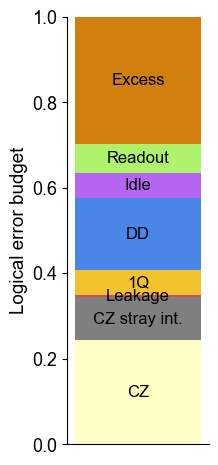

In [57]:
import matplotlib.pyplot as plt
from matplotlib import font_manager 
font_manager.fontManager.addfont('Arial.ttf')
plt.rcParams["font.family"] = "Arial"
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
plt.rcParams.update({'font.size': 13})

segments = [
    ("CZ",               ave_component_contribution["CZ"], "#fffec5"),  
    ("CZ stray int.",    ave_component_contribution["crosstalk"], "#7f7f7f"),  # gray
    ("Leakage",          ave_component_contribution["leakage"], "#cc4e63"),  # red
    ("1Q",               ave_component_contribution["SQ"], "#f2c22e"),  # yellow
    ("DD",               ave_component_contribution["DD"], "#4a86e8"),  # bule
    ("Idle",             ave_component_contribution["idle"], "#b565f2"),  # purple
    ("Readout",             ave_component_contribution["readout"], "#aff26c"),  # green
    ("Excess",           ave_component_contribution["Excess"], "#d1800f"), 
]
assert abs(sum(h for _, h, _ in segments) - 1.0) < 1e-9, "segments must sum to 1"

fig, ax = plt.subplots(figsize=(2, 4.5))

# 单根柱子的 x 位置与宽度
x = 0.0
width = 0.8

# 依次堆叠
bottom = 0.0
for label, height, color in segments:
    ax.bar(x, height, width, bottom = bottom, color = color, edgecolor = "none")
    # 居中写字：段比较窄时可以自动调小字号
    y_text = bottom + height/2
    fontsize = 12 if height >= 0.14 else 12
    ax.text(x, y_text, label, ha="center", va="center", color="black", fontsize = fontsize)
    bottom += height


ax.set_xlim(-0.45, 0.45)
ax.set_ylim(0, 1.0)
ax.set_xticks([])

# y 轴刻度 0–1
ax.set_yticks([i/5 for i in range(6)])  # 0,0.2,...,1.0
ax.set_ylabel("Logical error budget", fontsize = 13.5, rotation = 90, labelpad = 3)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# ax.bar(x, 1.0, width, fill=False, edgecolor="black", linewidth=1.5)

plt.subplots_adjust(left = 0.28, bottom = 0.02, top = 0.97, right = 0.99,  hspace = 0.0, wspace = 0.1) 
plt.show()
fig.savefig('Logical error budget.pdf', format='pdf', facecolor='None')

In [ ]:
color_list = ["maroon", "teal", "dimGray", "#FF8C00", "#BC8F8F", "#7FFFAA"]

marker_list = [ "o", "s", "d", "<", "p", "H" ]

plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 13})
fontsize = 13 ;

fig, (ax11, ax21) = plt.subplots( 1, 2,              
    figsize=(10, 5)   
)

spine_width = 1.5 ;

ax11.spines['top'].set_linewidth(spine_width)    
ax11.spines['bottom'].set_linewidth(spine_width) 
ax11.spines['left'].set_linewidth(spine_width)   
ax11.spines['right'].set_linewidth(spine_width)  
ax21.spines['top'].set_linewidth(spine_width)    
ax21.spines['bottom'].set_linewidth(spine_width) 
ax21.spines['left'].set_linewidth(spine_width)   
ax21.spines['right'].set_linewidth(spine_width)  

ax11.set_xlim(0, 7.2)
ax11.xaxis.set_major_locator(ticker.MultipleLocator(1))  

ax11.set_ylim(0, 1)
#----------------------------------------------------------------------
ax11.plot( cycle_t, sim_Z_logic_error["DD"], color = 'green', linestyle = "", linewidth=1, 
        marker = 'h', markerfacecolor='none', markeredgewidth=2.8, markersize = 9, label = 'Sim. Four' )

ax11.plot( cycle_interpo, pred_sim_Z_logic_error, color = 'black', linestyle = "dashed", linewidth=1.8)
#----------------------------------------------------------------------------------------------

handles, labels = ax11.get_legend_handles_labels()

ax11.text(4.5, 0.15, "Logical Z basis", fontsize=f'{fontsize}', color='black', ha='center', va='bottom')

ax11.set_xlabel(r'QEC cycle, $t$', labelpad = 3) 
ax11.set_ylabel(r'Logical error probability, $P_L(t)$', labelpad = 3) 


#---------------------------------------------------------------------------
ax21.set_xlim(0, 7.2)
ax21.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax21.yaxis.set_tick_params(labelleft=False)
ax21.set_ylim(0, 1)

##---------------------------------------------------------------------------
ax21.plot( cycle_t, sim_X_logic_error["DD"], color = 'green', linestyle = "", linewidth=1, 
        marker = 'h', markerfacecolor='none', markeredgewidth=2.8, markersize = 9, label = 'Sim. Four' )

ax21.plot( cycle_interpo, pred_sim_X_logic_error, color = 'black', linestyle = "dashed", linewidth=1.8)
##---------------------------------------------------------------------------

ax21.text(4.5, 0.15, "Logical X basis", fontsize=f'{fontsize}', color='black', ha='center', va='bottom')

ax21.set_xlabel(r'QEC cycle, $t$', labelpad = 3) 

plt.subplots_adjust(left = 0.07, bottom = 0.12, top = 0.83, right = 0.99,  hspace = 0.0, wspace = 0.1) 
plt.show()